<a href="https://colab.research.google.com/github/Sudiptagiri24/Churn-Prediciton-and-Chatbot/blob/main/churn_Chat_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
from nltk.stem import WordNetLemmatizer
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import torch

In [2]:
# Load the dataset
file_path = "churn prediction data.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customerID                     999 non-null    object 
 1   Gender                         999 non-null    object 
 2   Senior Citizen                 999 non-null    int64  
 3   Marital Status                 999 non-null    object 
 4   Dependents                     997 non-null    object 
 5   tenure in months               994 non-null    float64
 6   Priority Account               997 non-null    object 
 7   Credit Cards                   997 non-null    object 
 8   Loan Account                   998 non-null    object 
 9   Netbanking                     998 non-null    object 
 10  Debit Card                     999 non-null    object 
 11  MobileApp                      999 non-null    object 
 12  TechSupport Availed            998 non-null    obj

None

In [4]:
display(df.head())

,customerID,Gender,Senior Citizen,Marital Status,Dependents,tenure in months,Priority Account,Credit Cards,Loan Account,Netbanking,...,Zero Balance Account,FDs,Interest Deposited,Paperless Banking,Monthly Average Balance (USD),Yearly Average Balance (USD),Churn,Customer Feedback,Category,Recommendation
0,5522-JBWMO,Male,0,No,Yes,1.0,Yes,No,general loan,No,...,No,No,Month-to-month,No,44.0,44,No,My Credit Card is not generating OTP.,Credit Card,NaN
1,5275-PMFUT,Male,0,Yes,Yes,72.0,No,No,general loan,Yes,...,Yes,Yes,Two year,Yes,64.8,4719.75,No,The Current Account charges are too high.,Current Account,NaN
2,5609-CEBID,Female,1,No,No,20.0,Yes,Yes,top up loan,No,...,No,Yes,Month-to-month,Yes,94.1,1782.4,Yes,The loan prepayment charges are too high.,Loans,NaN
3,4381-MHQDC,Female,0,No,No,47.0,Yes,Yes,general loan,Yes,...,No,No,Two year,Yes,65.0,2879.9,No,The Savings Account opening process was very s...,Savings Account,NaN
4,6353-BRMMA,Female,0,Yes,Yes,54.0,Yes,Yes,top up loan,Yes,...,Yes,Yes,Month-to-month,Yes,104.1,5645.8,No,The loan documentation process is very complic...,Loans,NaN


In [5]:
# Check missing values
missing_values = df.isnull().sum()
display(missing_values[missing_values > 0])

,0
Dependents,2
tenure in months,5
Priority Account,2
Credit Cards,2
Loan Account,1
Netbanking,1
TechSupport Availed,1
Zero Balance Account,2
FDs,4
Paperless Banking,2


In [6]:
# Drop irrelevant columns
df.drop(columns=["customerID", "Recommendation"], inplace=True)

In [7]:
# Convert 'Yearly Average Balance (USD)' to numeric
df["Yearly Average Balance (USD)"] = pd.to_numeric(df["Yearly Average Balance (USD)"], errors='coerce')

In [8]:
# Fill missing values
## Numeric columns with mean
df["tenure in months"].fillna(df["tenure in months"].mean(), inplace=True)
df["Monthly Average Balance (USD)"].fillna(df["Monthly Average Balance (USD)"].mean(), inplace=True)
df["Yearly Average Balance (USD)"].fillna(df["Yearly Average Balance (USD)"].mean(), inplace=True)

<ipython-input-8-560d9bbbb899>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["tenure in months"].fillna(df["tenure in months"].mean(), inplace=True)
<ipython-input-8-560d9bbbb899>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [9]:
## Categorical columns with mode
categorical_cols = ["Dependents", "Priority Account", "Credit Cards", "Loan Account", "Netbanking",
                    "TechSupport Availed", "Zero Balance Account", "FDs", "Interest Deposited",
                    "Paperless Banking", "Churn", "Category"]
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-9-a2940d783def>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [10]:
newdf = df.copy()

In [11]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
categorical_features = df.select_dtypes(include=["object"]).columns
df[categorical_features] = df[categorical_features].apply(encoder.fit_transform)

In [12]:
# Handle outliers using IQR method
numeric_cols = df.select_dtypes(include=["number"]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

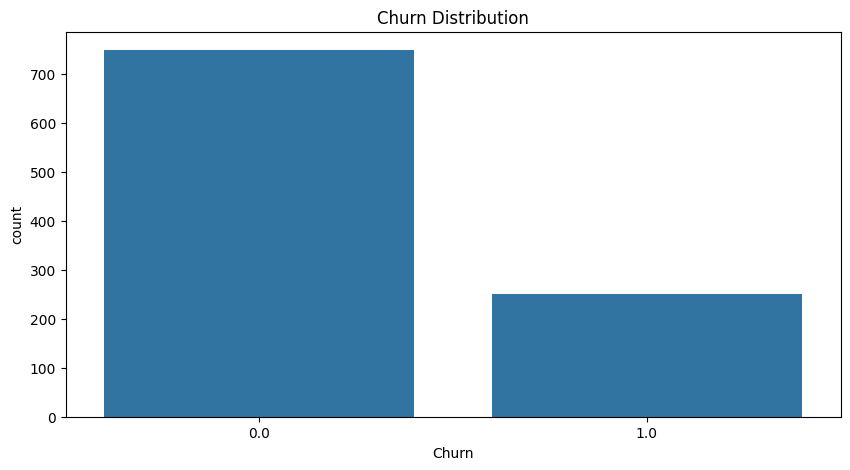

In [13]:
# Perform EDA
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Churn'])
plt.title("Churn Distribution")
plt.show()



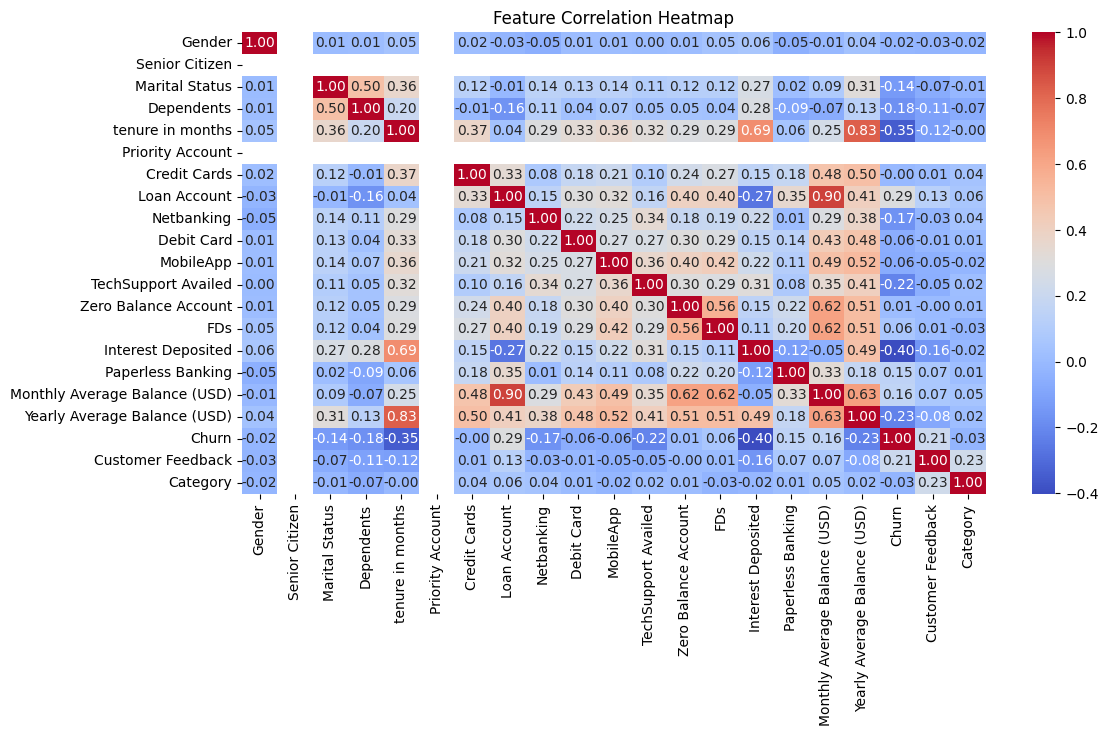

In [14]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Prepare data for modeling

In [15]:
X = df.drop(columns=["Churn"])
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# Standardize numerical features
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=["number"]).columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Train Logistic Regression Model

In [17]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Train Random Forest Model

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [19]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")


Model: Logistic Regression
Accuracy: 0.7600
Precision: 0.5882
Recall: 0.3704
F1-score: 0.4545
ROC-AUC: 0.6372
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       146
         1.0       0.59      0.37      0.45        54

    accuracy                           0.76       200
   macro avg       0.69      0.64      0.65       200
weighted avg       0.74      0.76      0.74       200


Model: Random Forest
Accuracy: 0.7950
Precision: 0.7097
Recall: 0.4074
F1-score: 0.5176
ROC-AUC: 0.6729
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       146
         1.0       0.71      0.41      0.52        54

    accuracy                           0.80       200
   macro avg       0.76      0.67      0.69       200
weighted avg       0.78      0.80      0.77       200



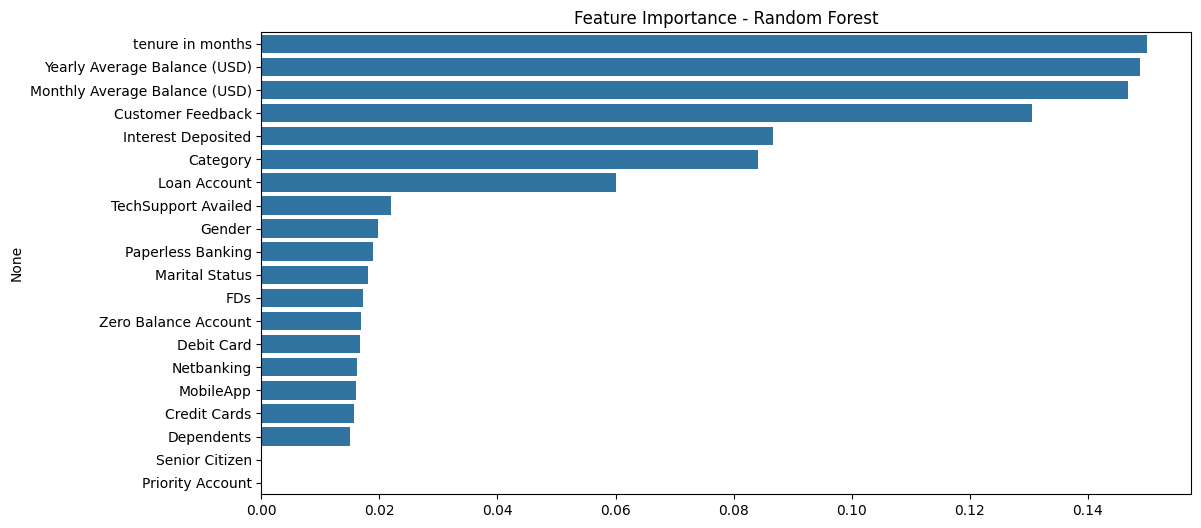

In [20]:
# Feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance - Random Forest")
plt.show()

In [21]:
newdf.head()

,Gender,Senior Citizen,Marital Status,Dependents,tenure in months,Priority Account,Credit Cards,Loan Account,Netbanking,Debit Card,...,TechSupport Availed,Zero Balance Account,FDs,Interest Deposited,Paperless Banking,Monthly Average Balance (USD),Yearly Average Balance (USD),Churn,Customer Feedback,Category
0,Male,0,No,Yes,1.0,Yes,No,general loan,No,No,...,No,No,No,Month-to-month,No,44.0,44.00,No,My Credit Card is not generating OTP.,Credit Card
1,Male,0,Yes,Yes,72.0,No,No,general loan,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,64.8,4719.75,No,The Current Account charges are too high.,Current Account
2,Female,1,No,No,20.0,Yes,Yes,top up loan,No,Yes,...,No,No,Yes,Month-to-month,Yes,94.1,1782.40,Yes,The loan prepayment charges are too high.,Loans
3,Female,0,No,No,47.0,Yes,Yes,general loan,Yes,No,...,Yes,No,No,Two year,Yes,65.0,2879.90,No,The Savings Account opening process was very s...,Savings Account
4,Female,0,Yes,Yes,54.0,Yes,Yes,top up loan,Yes,Yes,...,No,Yes,Yes,Month-to-month,Yes,104.1,5645.80,No,The loan documentation process is very complic...,Loans


# NLP for Customer Feedback Analysis

In [22]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [23]:
def preprocess_text(text):
    if not isinstance(text, str):  # Ensure input is a string
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)


In [24]:
from wordcloud import WordCloud
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
from wordcloud import WordCloud
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

<ipython-input-26-31725d8b9294>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  newdf['Processed_Feedback'].replace('', np.nan, inplace=True)


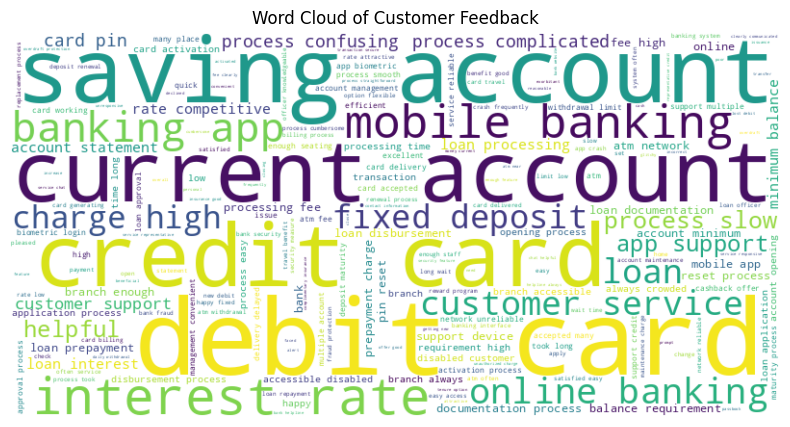

In [26]:
if 'Customer Feedback' in newdf.columns:
    newdf['Processed_Feedback'] = newdf['Customer Feedback'].dropna().apply(preprocess_text)

    # Remove empty strings after preprocessing
    newdf['Processed_Feedback'].replace('', np.nan, inplace=True)
    newdf.dropna(subset=['Processed_Feedback'], inplace=True)
    newdf['Processed_Feedback'] = newdf['Processed_Feedback'].astype(str)


    if not newdf['Processed_Feedback'].empty:
        # Generate Word Cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(newdf['Processed_Feedback']))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Word Cloud of Customer Feedback")
        plt.show()
    else:
        print("No valid feedback available for Word Cloud.")


# Generative AI for Retention Strategies

In [27]:
from cv2 import dnn

In [28]:
generator = pipeline("text-generation", model="gpt2", truncation=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [29]:
def generate_retention_message(risk_level, sentiment):
    prompt = f"Generate a customer retention message for a {risk_level} churn risk customer with {sentiment} feedback."
    response = generator(prompt, max_length=50, num_return_sequences=1, truncation=True)
    return response[0]['generated_text']

In [30]:
# Chatbot for Customer Queries
def chatbot_response(query):
    response = generator(f"Customer asked: {query}. Provide a helpful response:", max_length=50, num_return_sequences=1, truncation=True)
    return response[0]['generated_text']

In [31]:
# Example usage
user_message = "How can I reset my online banking passeword"
print("Chatbot:", chatbot_response(user_message))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Chatbot: Customer asked: How can I reset my online banking passeword. Provide a helpful response: http://www.custodianbanking.com/~martia/mw4-passeword.pdf For more on payday loans
